['img', 'msk']
(256, 256, 3)
Num img bands: (1, 2, 3, 4, 5, 6, 7)
sentinel12_s2_12_msk_1010.tif


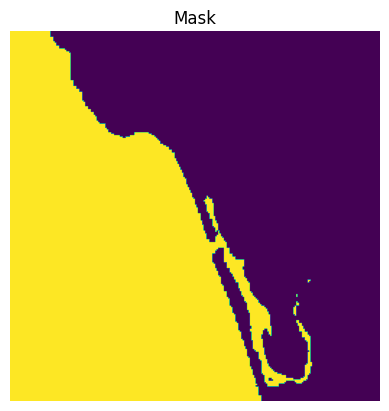

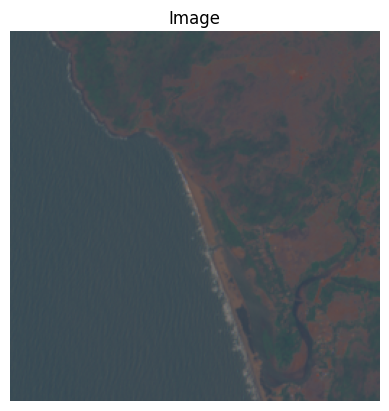

(256, 256, 3)
Num img bands: (1, 2, 3, 4, 5, 6, 7)
sentinel12_s2_12_msk_1035.tif


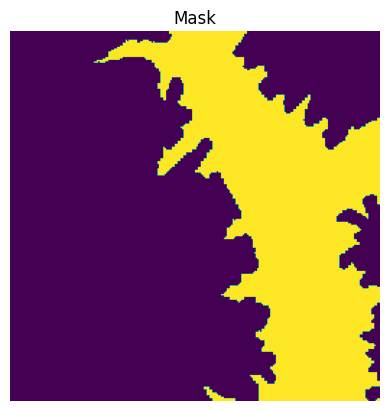

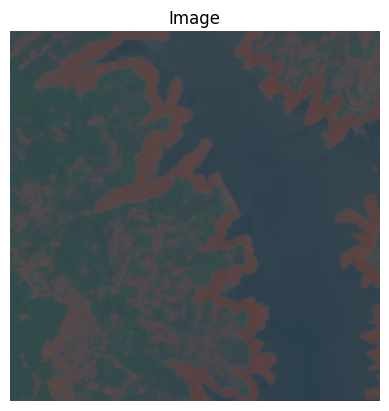

(256, 256, 3)
Num img bands: (1, 2, 3, 4, 5, 6, 7)
sentinel12_s2_12_msk_1052.tif


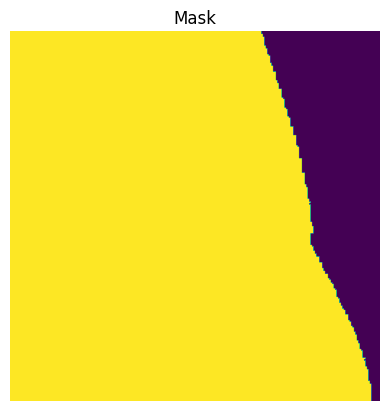

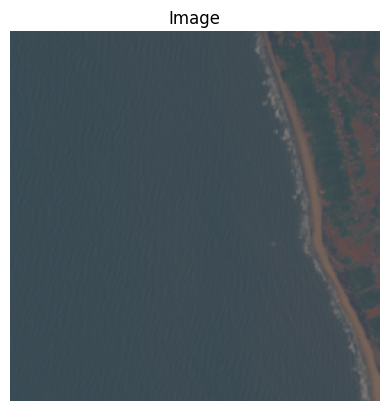

(256, 256, 3)
Num img bands: (1, 2, 3, 4, 5, 6, 7)
sentinel12_s2_12_msk_1077.tif


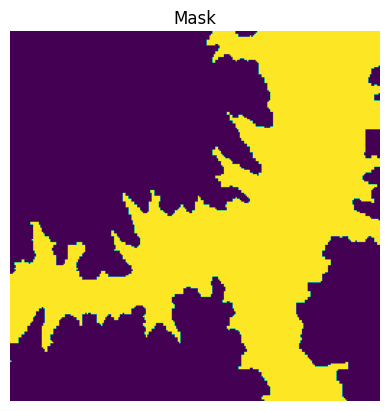

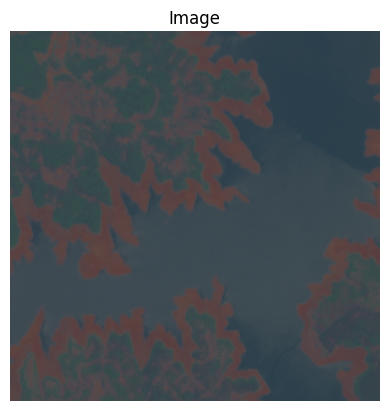

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import json
import random
import cv2

# From: https://stackoverflow.com/questions/32609098/how-to-fast-change-image-brightness-with-python-opencv
def increase_brightness(img, value=0.2):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

path = './data_prepped/train/'
print(os.listdir(path))
mask_folder = os.path.join(path, 'msk')
mask_files = sorted(os.listdir(mask_folder))
j = 0
for i in range(100):
    mask_path = os.path.join(mask_folder, mask_files[i])
    if os.path.isdir(mask_path):
        continue
        
    mask_data = rasterio.open(mask_path)
    mask = mask_data.read(1).astype(np.float32)

    img_data = rasterio.open(mask_path.replace('msk', 'img'))
    b, g, r, nir, swir1, swir2, slope  = img_data.read()
    rgb_img = np.stack((r,g,b), axis = -1).astype(np.float32)
    
    # Increase the brightness for better visibility (dataset is quite dark)
    rgb_img = increase_brightness(rgb_img)

    # Compute how many pixels are water, of the total image
    water_pixels = np.sum(mask==1)
    total_pixels = np.prod(mask.shape)
    water_ratio = water_pixels/total_pixels

    # Display images which are 30-90% water
    if water_ratio > 0.3 and water_ratio < 0.9:
        print(rgb_img.shape)
        print('Num img bands:', img_data.indexes)
        print(mask_files[i])

        img_file = mask_files[i].replace('.tif', '.png')

        # Display the water-no water mask
        plt.imshow(mask)
        plt.title('Mask')
        plt.axis('off')
        plt.savefig(f'./images/mask_{img_file}', bbox_inches='tight', transparent = True)
        plt.show()
        # Display the satellite image
        plt.imshow(rgb_img)
        plt.axis('off')
        plt.title('Image')
        plt.savefig(f'./images/img_{img_file}', bbox_inches='tight', transparent = True)
        plt.show()

        # Display at most 4 images
        j += 1
        if j == 5:
            break

### Image bands: "Blue": 0, "Green": 1, "Red": 2, "NIR": 3, "SWIR1": 4, "SWIR2": 5

In [2]:
b, g, r, nir, swir1, swir2, slope  = img_data.read()

In [7]:
np.max(b), np.min(b), np.max(g)

(0.2958, 0.1007, 0.3127)

In [3]:
andwi = (b+g+r-nir-swir1-swir2) / (b+g+r+nir+swir1+swir2)
ndwi = (g-nir)/(g+nir)
print(andwi)
print(ndwi >= 0.3)

[[-0.26354727 -0.2238246  -0.20787147 ... -0.0862821  -0.08495822
  -0.10117304]
 [-0.27426162 -0.24482073 -0.23468672 ... -0.09207445 -0.08701508
  -0.10072569]
 [-0.2270541  -0.16778658 -0.19219959 ... -0.09433468 -0.11259339
  -0.11817444]
 ...
 [-0.18356232 -0.14488456 -0.20906615 ... -0.18107371 -0.15788074
  -0.15864104]
 [-0.13435008 -0.12999007 -0.20953478 ... -0.18770635 -0.17520706
  -0.1713428 ]
 [-0.14281498 -0.12953067 -0.18709004 ... -0.19503863 -0.17953318
  -0.16692588]]
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [4]:
import ukis_metrics.seg_metrics as segm
# tpfptnfn = segm.tpfptnfn(y_true, y_pred, None)
# metrics = segm.segmentation_metrics(tpfptnfn)

for threshold in [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]:
    tpfptnfn = segm.tpfptnfn(mask == 1, ndwi >= threshold, None)
    metrics = segm.segmentation_metrics(tpfptnfn)
    print(f'Threshold = {threshold}\t{metrics}')

Threshold = 0.0	{'iou': 0.852, 'recall': 1.0, 'precision': 0.852, 'acc': 0.9996, 'F1': 0.9201, 'kappa': 0.9199}
Threshold = 0.1	{'iou': 0.8256, 'recall': 0.8503, 'precision': 0.966, 'acc': 0.9995, 'F1': 0.9045, 'kappa': 0.9042}
Threshold = 0.3	{'iou': 0.0, 'recall': 0.0, 'precision': 0.0, 'acc': 0.9975, 'F1': 0.0, 'kappa': 0.0}
Threshold = 0.5	{'iou': 0.0, 'recall': 0.0, 'precision': 0.0, 'acc': 0.9975, 'F1': 0.0, 'kappa': 0.0}
Threshold = 0.7	{'iou': 0.0, 'recall': 0.0, 'precision': 0.0, 'acc': 0.9975, 'F1': 0.0, 'kappa': 0.0}
Threshold = 0.9	{'iou': 0.0, 'recall': 0.0, 'precision': 0.0, 'acc': 0.9975, 'F1': 0.0, 'kappa': 0.0}
Threshold = 1.0	{'iou': 0.0, 'recall': 0.0, 'precision': 0.0, 'acc': 0.9975, 'F1': 0.0, 'kappa': 0.0}


In [5]:
print(img_data.meta)
print(img_data.bounds)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 256, 'height': 256, 'count': 7, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0)}
BoundingBox(left=0.0, bottom=256.0, right=256.0, top=0.0)
